In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.stats import binom

from variance import *

# Living in ARR/HW where only critical hits exist

This easier to start with will also be helpful for comparing the variance of damage distributions where hits can be CHs, DHs, and CDHs.

In [3]:
def hits2pot(k, n, l_c, d2, buffs=None):
    """
    Convert hit types to damage dealt.


    """

    if buffs is None:
        buff_prod = 1
    else:
        buff_prod = np.prod(buffs)
    
    potency = np.zeros(k.size)
    avg_crit = np.floor(np.floor(d2*l_c) / 1000)
    a_n = np.floor(0.95 * d2)
    b_n = np.floor(1.05 * d2) + 1

    a_c = np.floor(0.95 * avg_crit)
    b_c = np.floor(1.05 * avg_crit) + 1

    for x in range(k.size):
        norm_dmg = np.floor(np.random.randint(a_n, b_n, size=(n-k[x])) * buff_prod)
        crit_dmg = np.floor(np.random.randint(a_c, b_c, size=(k[x])) * buff_prod)
        potency[x] = np.sum(norm_dmg) + np.sum(crit_dmg)

    return potency

def dots2pot(k, n, l_c, d2, buffs=None):

    if buffs is None:
        buff_prod = 1
    else:
        buff_prod = np.prod(buffs)
    
    potency = np.zeros(k.size)
    a_n = np.floor(0.95 * d2)
    b_n = np.floor(1.05 * d2) + 1
    
    print(a_n, b_n)
    for x in range(k.size):
        norm_dmg = np.floor(np.random.randint(a_n, b_n, size=n-k[x]) * buff_prod)
        crit_dmg = np.floor(np.floor(np.floor(np.random.randint(a_n, b_n, size=(k[x])) * l_c) / 1000) * buff_prod)
        potency[x] = np.sum(norm_dmg) + np.sum(crit_dmg)

    return potency   

## Compute mean and variance skill landing $n$ hits

First setup some functions to find the support of single-hit damage distributions

In [4]:
def skill_mean(d2, n, p_c, l_c, buffs=None):
    if buffs is None:
        buff_prod = 1
    else:
        buff_prod = np.prod(buffs)

    normal_supp = nh_supp(d2, buffs)
    S_N = normal_supp.size
    Z_N = np.sum(normal_supp)

    crit_supp = ch_supp(d2, l_c, buffs)
    S_C = crit_supp.size
    Z_C = np.sum(crit_supp)

    # k = np.arange(0, n+1)
    # binom_weights = binom(n, p_c).pmf(k)
    return sum([binom(n, p_c).pmf(k) * (k * Z_C / S_C + ((n - k) * Z_N) / S_N ) for k in range(n+1)])

def skill_var(d2, n, p_c, l_c, buffs=None):
    if buffs is None:
        buff_prod = 1
    else:
        buff_prod = np.prod(buffs)

    normal_supp = nh_supp(d2, buffs)
    S_N = normal_supp.size
    Z_N = np.sum(normal_supp)
    Z_N2 = np.sum(normal_supp**2)

    crit_supp = ch_supp(d2, l_c, buffs)
    S_C = crit_supp.size
    Z_C = np.sum(crit_supp)
    Z_C2 = np.sum(crit_supp**2)

    second_deriv = sum([binom(n, p_c).pmf(k)*((n**2*Z_N**2)/S_N**2 \
        + k**2*(Z_C**2/S_C**2 - (2*Z_C*Z_N)/(S_C*S_N) + Z_N**2/S_N**2) \
        + k*(-(Z_C**2/S_C**2) + Z_C2/S_C + Z_N**2/S_N**2  \
        + n*((2*Z_C*Z_N)/(S_C*S_N) - (2*Z_N**2)/S_N**2) - Z_N2/S_N) \
        + n*(-(Z_N**2/S_N**2) + Z_N2/S_N)) for k in range(n+1)])
    
    return second_deriv - skill_mean(d2, n, p_c, l_c, buffs)**2

DoT moment functions differ in how $S_i$ and $Z_i$ are found. Actual formulae for the moments are the same.

In [5]:
def dot_mean(d2, n, p_c, l_c, buffs=None):
    """
    Compute the mean of the damage distribution for n DoT ticks.
    """
    normal_supp = dot_nh_supp(d2, buffs)
    S_N = normal_supp.size
    Z_N = np.sum(normal_supp)
    
    ch_supp = dot_ch_supp(d2, l_c, buffs)
    S_C = ch_supp.size
    Z_C = np.sum(ch_supp)

    return sum([binom(n, p_c).pmf(k) * (k * Z_C / S_C + ((n - k) * Z_N) / S_N ) for k in range(n+1)])

def dot_var(d2, n, p_c, l_c, buffs=None):
    """
    Compute the variance of the damage distribution for n DoT ticks.
    """
    normal_supp = dot_nh_supp(d2, buffs)
    S_N = normal_supp.size
    Z_N = np.sum(normal_supp)
    Z_N2 = np.sum(normal_supp**2)

    ch_supp = dot_ch_supp(d2, l_c, buffs)
    S_C = ch_supp.size
    Z_C = np.sum(ch_supp)
    Z_C2 = np.sum(ch_supp**2)

    second_deriv = sum([binom(n, p_c).pmf(k)*((n**2*Z_N**2)/S_N**2 \
        + k**2*(Z_C**2/S_C**2 - (2*Z_C*Z_N)/(S_C*S_N) + Z_N**2/S_N**2) \
        + k*(-(Z_C**2/S_C**2) + Z_C2/S_C + Z_N**2/S_N**2  \
        + n*((2*Z_C*Z_N)/(S_C*S_N) - (2*Z_N**2)/S_N**2) - Z_N2/S_N) \
        + n*(-(Z_N**2/S_N**2) + Z_N2/S_N)) for k in range(n+1)])
    
    return second_deriv - dot_mean(d2, n, p_c, l_c, buffs)**2

## Compute mean and variance of a rotation

In [6]:
def rotation_mean(d, n, p_c, l_c, buffs=None):
    return sum([skill_mean(d[x], n[x], p_c, l_c, buffs) for x in range(len(n))])

def rotation_var(d, n, p_c, l_c, buffs=None):
    return sum([skill_var(d[x], n[x], p_c, l_c, buffs) for x in range(len(n))])

### Some parameters used in the figures



In [7]:
# Abritrarily selecting crit rate and damage multiplier for illustration
p_c = 0.35
l_c = 1500

## Non-DoT damage distribution

In [8]:
k_1 = np.random.binomial(1, p_c, size=1000000)
k_2 = np.random.binomial(2, p_c, size=1000000)
dmg_dist1 =  hits2pot(k_1, 1, l_c, 100, [1.1])
dmg_dist2 =  hits2pot(k_2, 2, l_c, 100, [1.1])

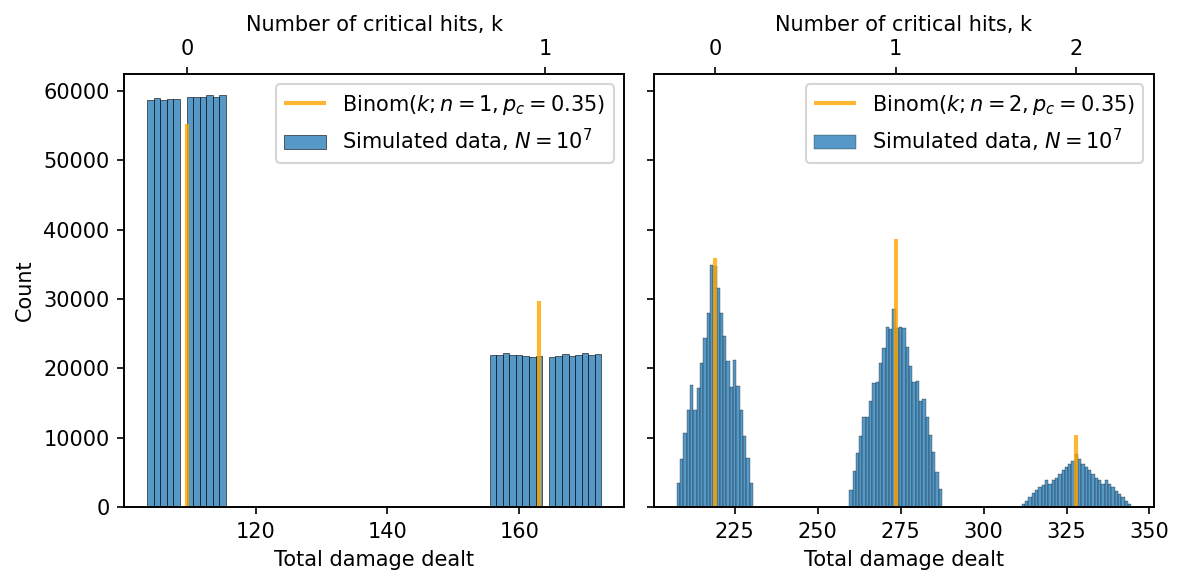

In [9]:
# Stuff for the vline binom plots
d2 = 100
buff_prod = 1.1

nh_dmg = np.mean(nh_supp(d2, [1.1]))
crit_dmg = np.mean(ch_supp(d2, l_c, [1.1]))

fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=150, sharey=True)

n = 1
k = np.arange(0,n+1)
sns.histplot(dmg_dist1, discrete=True, bins=150, ax=ax[0], label='Simulated data, $N = 10^7$')
rv = binom(n, p_c)
x = k*(crit_dmg - nh_dmg) + n*nh_dmg
x[1] -= 1
ax[0].vlines(x, 0, rv.pmf(np.arange(n+1))*85000, colors='orange', linestyles='-', lw=2, label=r'Binom$(k;n=1,p_c=0.35)$', alpha=0.8)

ax[0].set_xlabel('Total damage dealt')
ax2 = ax[0].twiny()
x_label = list(map(str,range(0,n+1)))
x_tick = np.arange(0,n+1)*(crit_dmg - nh_dmg) + n*nh_dmg


ax2.set_xlim(ax[0].get_xlim())
ax2.set_xticks(x_tick)
ax2.set_xticklabels(x_label)
ax2.set_xlabel('Number of critical hits, k')



#### Second plot ####

sns.histplot(dmg_dist2, discrete=True, bins=150, ax=ax[1], label='Simulated data, $N = 10^7$')

n = 2

rv = binom(n, p_c)
x = np.arange(0,n+1)*(crit_dmg - nh_dmg) + n*nh_dmg
ax[1].vlines(x, 0, rv.pmf(np.arange(n+1))*85000, colors='orange', linestyles='-', lw=2, label=r'Binom$(k;n=2,p_c=0.35)$', alpha=0.8)

ax[1].set_xlabel('Total damage dealt')
ax2 = ax[1].twiny()
x_label = list(map(str,range(0,n+1)))
x_tick = np.arange(0,n+1)*(crit_dmg - nh_dmg) + n*nh_dmg


ax2.set_xlim(ax[1].get_xlim())
ax2.set_xticks(x_tick)
ax2.set_xticklabels(x_label)
ax2.set_xlabel('Number of critical hits, k')

ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

In [10]:
print(nh_supp(d2, [1.1]).size, nh_supp(d2, [1.1]))
print(ch_supp(d2, l_c, [1.1]).size, ch_supp(d2, l_c, [1.1]))

11 [104. 105. 106. 107. 108. 110. 111. 112. 113. 114. 115.]
16 [156. 157. 158. 159. 160. 161. 162. 163. 165. 166. 167. 168. 169. 170.
 171. 172.]


In [11]:
x = dmg_dist2
n = 2

print('Sim mean:   {:5.3f} |'.format(np.mean(x)), 'Sim StD:   {:5.3f}'.format(np.std(x)))
print('Exact mean: {:5.3f} |'.format(skill_mean(100, n, p_c, l_c, [1.1])), 'Exact StD: {:5.3f}'.format(skill_var(100, n, p_c, l_c, [1.1])**(0.5)))


Sim mean:   257.217 | Sim StD:   37.235
Exact mean: 257.209 | Exact StD: 37.201


## DoT damage distribution

In [12]:
k_1 = np.random.binomial(1, p_c, size=1000000)
k_2 = np.random.binomial(2, p_c, size=1000000)
dot_dmg_dist1 =  dots2pot(k_1, 1, l_c, 100, [1.1])
dot_dmg_dist2 =  dots2pot(k_2, 2, l_c, 100, [1.1])

95.0 106.0
95.0 106.0


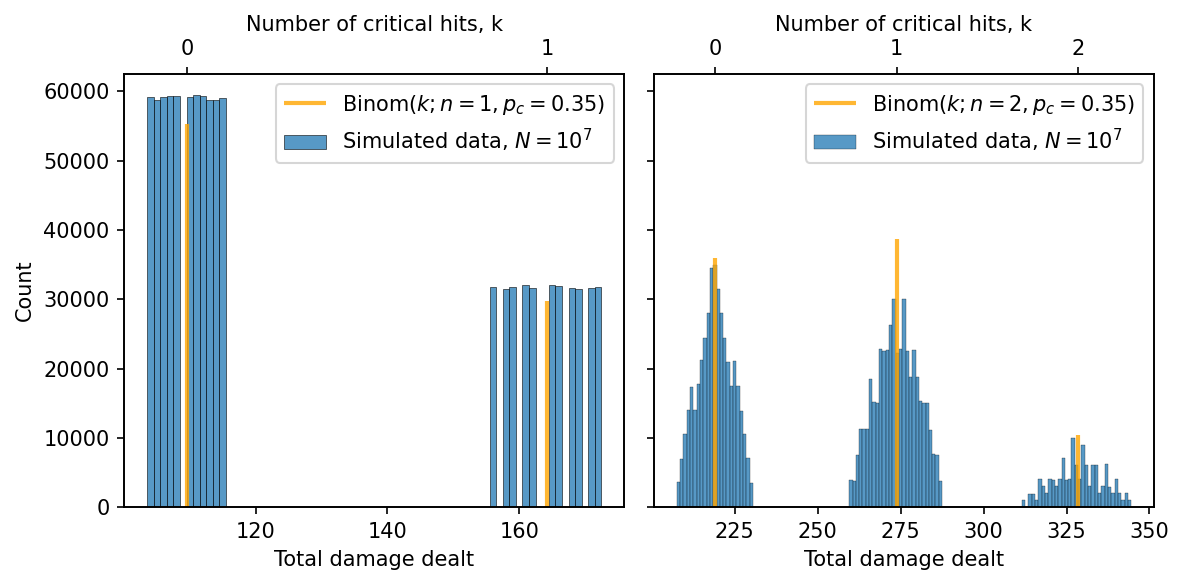

In [13]:
d2 = 100
# Stuff for the vline binom plots
d2 = 100
buff_prod = 1.1

nh_dmg = np.mean(dot_nh_supp(d2, [1.1]))
crit_dmg = np.mean(dot_ch_supp(d2, l_c, [1.1]))

fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=150, sharey=True)

n = 1
k = np.arange(0,n+1)

sns.histplot(dot_dmg_dist1, discrete=True, bins=150, ax=ax[0], label='Simulated data, $N = 10^7$')
rv = binom(n, p_c)
x = k*(crit_dmg - nh_dmg) + n*nh_dmg
ax[0].vlines(x, 0, rv.pmf(np.arange(n+1))*85000, colors='orange', linestyles='-', lw=2, label=r'Binom$(k;n=1,p_c=0.35)$', alpha=0.8)

ax[0].set_xlabel('Total damage dealt')
ax2 = ax[0].twiny()
x_label = list(map(str,range(0,n+1)))
x_tick = np.arange(0,n+1)*(crit_dmg - nh_dmg) + n*nh_dmg


ax2.set_xlim(ax[0].get_xlim())
ax2.set_xticks(x_tick)
ax2.set_xticklabels(x_label)
ax2.set_xlabel('Number of critical hits, k')



#### Second plot ####

sns.histplot(dot_dmg_dist2, discrete=True, bins=150, ax=ax[1], label='Simulated data, $N = 10^7$')

n = 2
k = np.arange(0,n+1)

rv = binom(n, p_c)
x = k*(crit_dmg - nh_dmg) + n*nh_dmg
ax[1].vlines(x, 0, rv.pmf(np.arange(n+1))*85000, colors='orange', linestyles='-', lw=2, label=r'Binom$(k;n=2,p_c=0.35)$', alpha=0.8)

ax[1].set_xlabel('Total damage dealt')
ax2 = ax[1].twiny()
x_label = list(map(str,range(0,n+1)))
x_tick = np.arange(0,n+1)*(crit_dmg - nh_dmg) + n*nh_dmg


ax2.set_xlim(ax[1].get_xlim())
ax2.set_xticks(x_tick)
ax2.set_xticklabels(x_label)
ax2.set_xlabel('Number of critical hits, k')

ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

In [14]:
x = dot_dmg_dist2
n = 2

print('Sim mean:   {:5.3f} |'.format(np.mean(x)), 'Sim StD:   {:5.3f}'.format(np.std(x)))
print('Exact mean: {:5.3f} |'.format(dot_mean(100, n, p_c, l_c, [1.1])), 'Exact StD: {:5.3f}'.format(dot_var(100, n, p_c, l_c, [1.1])**(0.5)))

Sim mean:   257.337 | Sim StD:   37.371
Exact mean: 257.400 | Exact StD: 37.396


# Example: 1 Skill, 1 DoT

In [15]:
d1 = 20000
d2 = 5000 # This is a dot

n1 = 50
n2 = 50

d = np.array([d1, d2])
n = np.array([n1, n2])

# one of the whm builds
crit = 3731

# Actually compute the proper crit rate and dmg modifier now
p_c = crit_prob(crit)
l_c = crit_dmg_multiplier(crit)

# Convert total dmg dealt to dps, assume 2.50s gcd
n_hits = 50
gcd = 2.5

dmg2dps = 1/(2.5*n_hits)

p_c, l_c, dmg2dps

(0.253, 1603.0, 0.008)

In [16]:
x_1 = np.random.binomial(n[0], p_c, 500000)
x_2 = np.random.binomial(n[1], p_c, 500000)

rotation_dmg_dist =  hits2pot(x_1, n[0], l_c, d[0]) + dots2pot(x_2, n[1], l_c, d[1])

4750.0 5251.0


In [17]:
x = rotation_dmg_dist * dmg2dps

# Kind of clunky because I didn't make a way to differentiate not DoTs and DoTs
exact_mean = (skill_mean(d[0], n[0], p_c, l_c) + dot_mean(d[1], n[1], p_c, l_c)) * dmg2dps
exact_std = np.sqrt(skill_var(d[0], n[0], p_c, l_c) + dot_var(d[1], n[1], p_c, l_c)) * dmg2dps
exact_rel_std = exact_std / exact_mean

print('Sim mean:   {:5.3f} |'.format(np.mean(x)), 'Sim StD:   {:5.3f}'.format(np.std(x)))
print('Exact mean: {:5.3f} |'.format(exact_mean), 'Exact StD: {:5.3f}'.format(exact_std))
print('{:0.4f}'.format(exact_rel_std))
print('Sample skew: {:0.4f}'.format(skew(x)))


Sim mean:   11525.162 | Sim StD:   308.640
Exact mean: 11525.540 | Exact StD: 308.287
0.0267
Sample skew: 0.1490


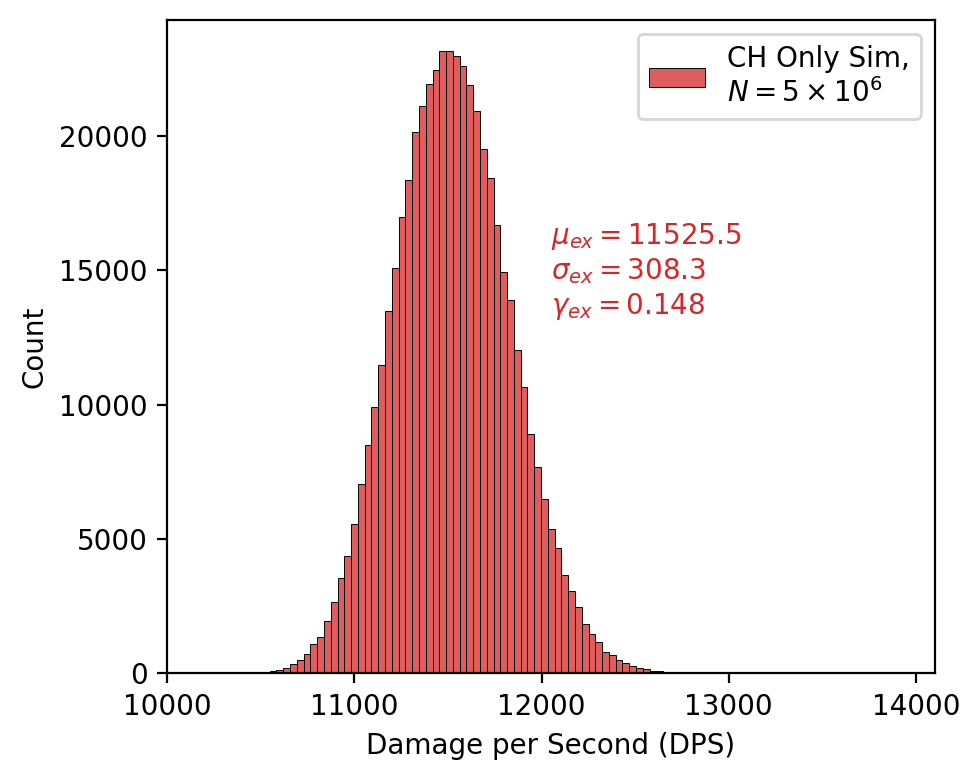

In [18]:
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=200, sharey=True)

sns.histplot(rotation_dmg_dist * dmg2dps, bins=75, ax=ax, label='CH Only Sim,\n'+r'$N = 5 \times 10^6$', color='C3')

ax.set_xlabel('Damage per Second (DPS)')
ax.legend()

# Copy pasting this from the other nb
exact_skew = 0.14849251504580294
anno1 = r'$\mu_{ex} = $' + '{:.1f}'.format(exact_mean)
anno1 += '\n'
anno1 += r'$\sigma_{ex} = $' + '{:.1f}'.format(exact_std)
anno1 += '\n'
anno1 += r'$\gamma_{ex} = $' + '{:.3f}'.format(exact_skew)
ax.annotate(anno1, xy=(0.5, 0.55), xycoords='axes fraction', color='C3')

ax.set_xlim([10000, 14100])
ax.set_xticks(np.arange(10000, 15000, 1000))
plt.tight_layout()
plt.show()

# Example: 1-2-3 rotation with a DoT and 10% damage buff

In [19]:
# Det/Ten will enter here but I'm just assuming nice values
# because I dont want to code up everything needed to compute D2
d1 = 13000
d2 = 20000
d3 = 25000
d4 = 35000
d5 = 3000 # This is a dot

n1 = 25
n2 = 25
n3 = 25
n4 = 5
n5 = 75 # This is a dot

d = np.array([d1, d2, d3, d4, d5])
n = np.array([n1, n2, n3, n4, n5])

# I think this is from 5.4 DRG BiS idk
crit = 4069

# Actually compute the proper crit rate and dmg modifier now
p_c = crit_prob(crit)
l_c = crit_dmg_multiplier(crit)

# Persistent 10% dmg buff
b = [1.1]

n_hits = 75
gcd = 2.5

dmg2dps = 1/(2.5*n_hits)

### Run the sim

In [20]:
x_1 = np.random.binomial(n[0], p_c, 500000)
x_2 = np.random.binomial(n[1], p_c, 500000)
x_3 = np.random.binomial(n[2], p_c, 500000)
x_4 = np.random.binomial(n[3], p_c, 500000)
x_5 = np.random.binomial(n[4], p_c, 500000)

rotation_dmg_dist =  hits2pot(x_1, n[0], l_c, d[0], b) + hits2pot(x_2, n[1], l_c, d[1], b) + hits2pot(x_3, n[2], l_c, d[2], b) + hits2pot(x_4, n[3], l_c, d[3], b) + dots2pot(x_5, n[4], l_c,d[4], b)

2850.0 3151.0


In [21]:
x = rotation_dmg_dist * dmg2dps

# Kind of clunky because I didn't make a way to differentiate not DoTs and DoTs
exact_mean = (rotation_mean(d[0:4], n[0:4], p_c, l_c, b) + dot_mean(d[4], n[4], p_c, l_c, b)) * dmg2dps
exact_std = np.sqrt(rotation_var(d[0:4], n[0:4], p_c, l_c, b) + dot_var(d[4], n[4], p_c, l_c, b)) * dmg2dps
exact_rel_std = exact_std / exact_mean

print('Sim mean:   {:5.3f} |'.format(np.mean(x)), 'Sim StD:   {:5.3f}'.format(np.std(x)))
print('Exact mean: {:5.3f} |'.format(exact_mean), 'Exact StD: {:5.3f}'.format(exact_std))
print('{:0.4f}'.format(exact_rel_std))
print('Sample skew: {:0.4f}'.format(skew(x)))

Sim mean:   12699.023 | Sim StD:   314.846
Exact mean: 12698.781 | Exact StD: 314.142
0.0247
Sample skew: 0.1234


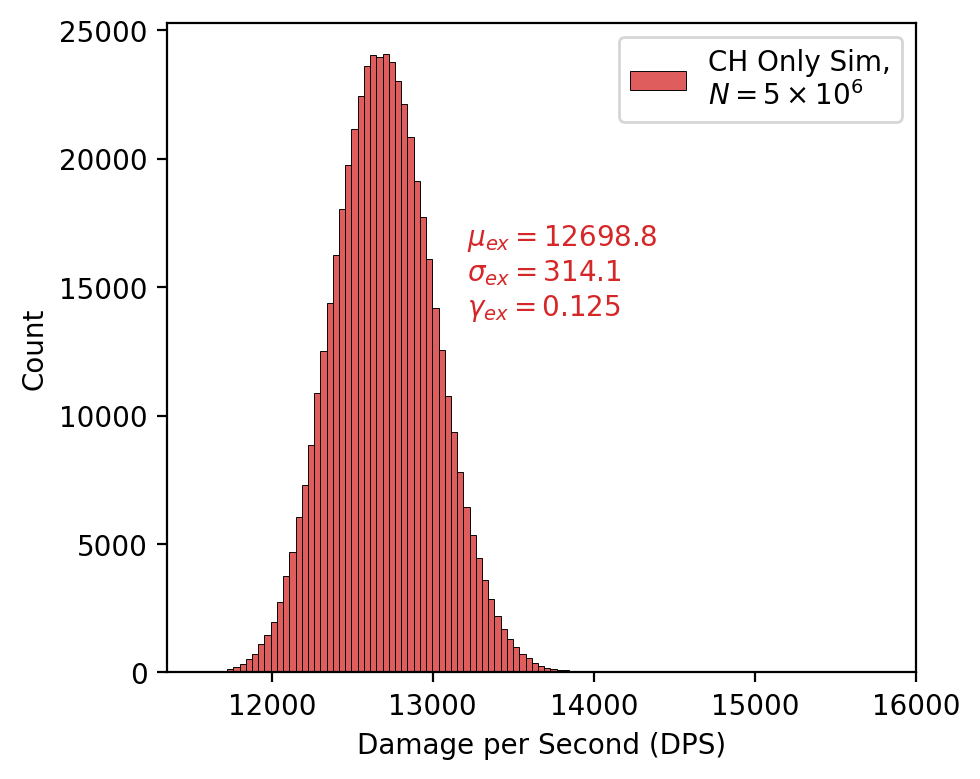

In [22]:
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=200, sharey=True)

# Convert total dmg dealt to dps, assume 2.50s gcd
n_hits = 75
gcd = 2.5

dmg2dps = 1/(2.5*n_hits)

sns.histplot(rotation_dmg_dist * dmg2dps, bins=75, ax=ax, label='CH Only Sim,\n'+r'$N = 5 \times 10^6$', color='C3')

ax.set_xlabel('Damage per Second (DPS)')
ax.legend()

# from the all-hits nb
exact_skew = 0.12514683281685934

anno1 = r'$\mu_{ex} = $' + '{:.1f}'.format(exact_mean)
anno1 += '\n'
anno1 += r'$\sigma_{ex} = $' + '{:.1f}'.format(exact_std)
anno1 += '\n'
anno1 += r'$\gamma_{ex} = $' + '{:.3f}'.format(exact_skew)
ax.annotate(anno1, xy=(0.4, 0.55), xycoords='axes fraction', color='C3')
# print(ax.get_xlim())
ax.set_xlim([11350, 16000])
plt.tight_layout()
plt.show()